# Lesson: Distributed ML - WRANGLE
<a href = "https://www.canva.com/design/DAFnDqY3h6A/nTll6C14hN-N9nzsOzm9RQ/view?utm_content=DAFnDqY3h6A&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink">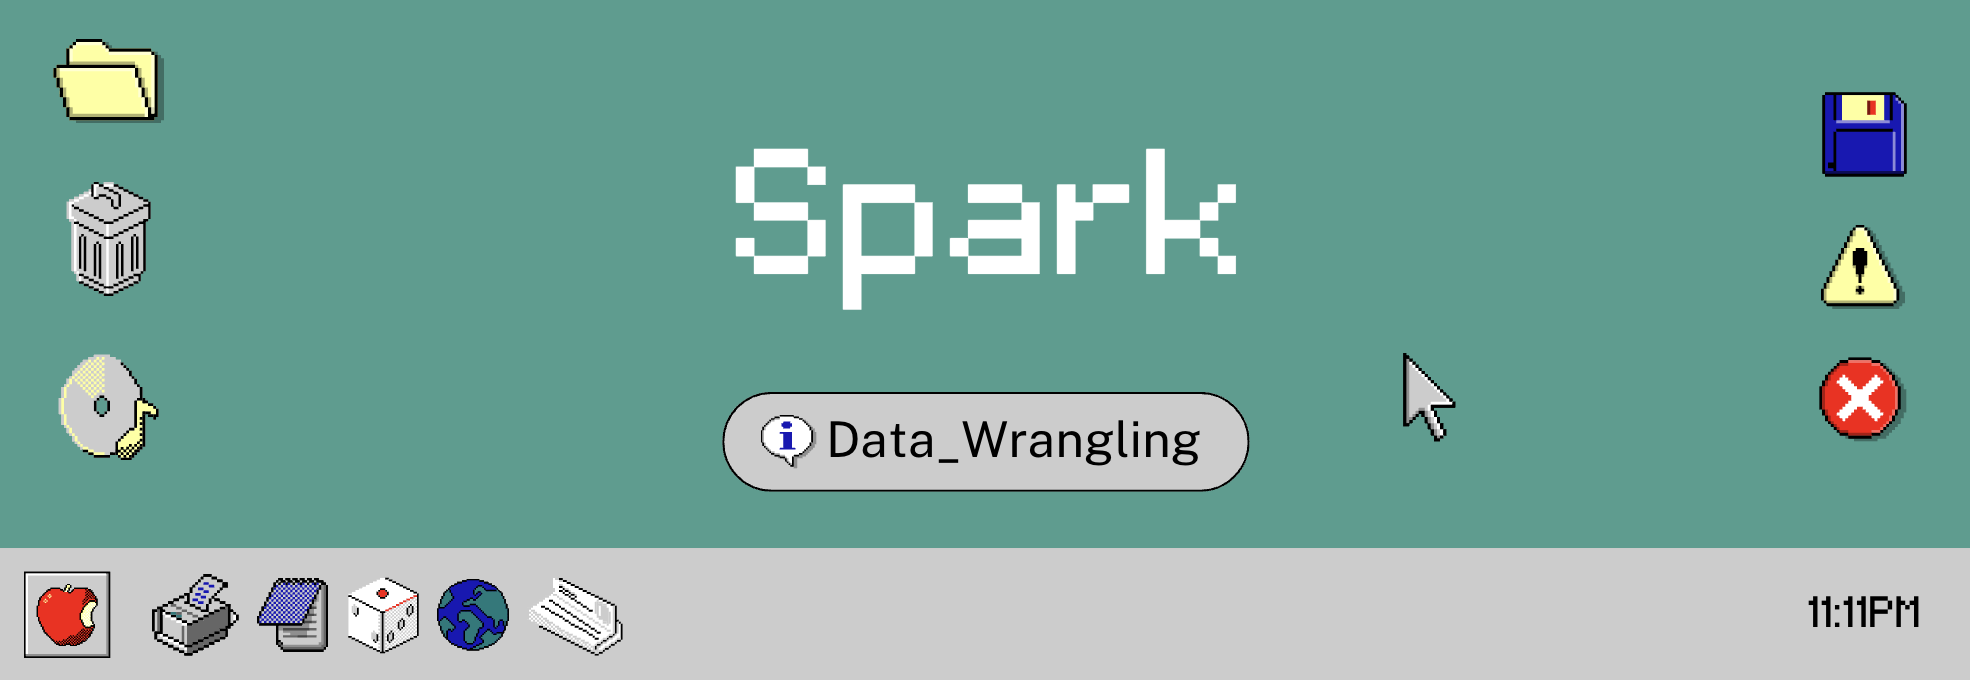</a>

<hr style="border:2px solid gray">

# Imports

In [ ]:
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd


<a href="https://spark.apache.org/docs/3.1.3/api/python/reference/pyspark.sql.html#dataframe-apis">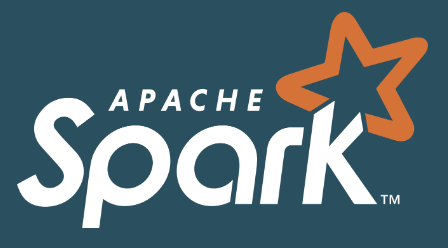</a>

In [ ]:
# Generate spark object to initialize a local Spark JVM process
spark = 

#### The message above is **not** an error message, simply letting us know that only warning messages and higher severity levels will be logged.
> ##### By default, the PySpark logs are primarily outputted in the JVM logs, but you can redirect the standard output and error streams to save them locally for further analysis or debugging purposes.

___
# Reading Data

In [ ]:
df = 

df

Like most things spark, there's multiple ways to do it:

In [ ]:
(
    spark.read.format("csv")
    .option
    .option
    .option
    .load
)

Notice the human-readable schema is outputted!

In [ ]:
# as opposed to the actual schema object associated with the DataFrame


In [ ]:
# This schema can be specified/assigned initially to (possibly) speed up loading of data
schema = StructType()

spark.read.csv()

In [ ]:
df.show()

___
# Writing Data
We can write to:
- `json`: for writing to a local json file(s)
- `csv`: for writing to a local csv file(s)
- `parquet`: Parquet is a very popular columnar storage format for Hadoop.
- `jdbc`: for writing to a SQL database table

In [ ]:
# for demo purposes
from pydataset import data

#### write file to json

In [ ]:
mpg = 

mpg

#### write dataframe to csv

In [ ]:
# Or...


### read files
- spark.read.[type]

In [ ]:
spark

In [ ]:
spark

# Data Preparation

For the rest of this lesson, we'll take a look at the `case` data from the San Antonio 311 calls dataset.

In [ ]:
df = spark.read.csv("case.csv", header=True, inferSchema=True)
df #Default: True = truncate strings longer than 20 chars

In [ ]:
# eww...


We will now cover various pieces of data preparation we wish to do and how to do those with spark.

## Rename Columns

We'll rename this column to match with the other date-type columns.

In [ ]:
df = 
df.show(2, vertical=True)

## Correct Data Types

<div class="alert alert-info" role="alert">

Two columns, `case_closed` and `case_late` store yes/no values. Currently spark thinks they are strings
- Let's turn them into booleans:

</div>

In [ ]:
# demonstrating we only have yes/no in each field


In [ ]:
#Let's create two new boolean columns
df = 

#Select just the two columns


<div class="alert alert-info" role="alert">

The `council_district` column appears as though it is an integer, but this is just a unique identifier for each district, that is, we aren't going to be performing arithmetic with this number
- so we will turn it into a string type.

</div>

In [ ]:
df = 

<div class="alert alert-info" role="alert">

Now we'll use spark's  `to_timestamp` function to handle the 3 columns that have dates in them. 
    
In order to work properly, we'll need to provide the date format when using `to_timestamp`. 
The date format is a little different than the date functionality we've worked with in pandas, this is because it is using [Java's `SimpleDateFormat`][1].

[1]: https://docs.oracle.com/javase/7/docs/api/java/text/SimpleDateFormat.html

</div>

In [ ]:
#Before
df.select('case_opened_date', 'case_closed_date', 'case_due_date').show(5)

In [ ]:
#After

fmt = 

df = 

df.select("case_opened_date", "case_closed_date", "case_due_date").show(5)

## Data Transformations

Now that we have everything stored as the correct data type, we will make a few transformations to the data.

<div class="alert alert-info" role="alert">

We'll begin by normalizing the request address field. 

Using the `trim` and `lower` functions let's strip any leading or trailing whitespace and convert everything to lowercase.

</div>

In [ ]:
#Before
df.select("request_address").show(5)

In [ ]:
#After
df = 

df.select("request_address").show(5)

<div class="alert alert-info" role="alert">

Here we will convert the number of days a case is late to a number of weeks.

</div>

In [ ]:
df = 

df.select("num_days_late", "num_weeks_late").show(5)

<div class="alert alert-info" role="alert">

Lastly, we can format the `council_district` column a little differently. 
- We'll add leading 0s to it:

</div>

In [ ]:
df = 

# '%03d' means at least 3 digits, pad with 0s
#
# In order to use the format_string function the way we are, we'll need to
# convert council_district back to an integer temporarily, but the final output
# will be a string.
df = 

df.select("council_district").show(5)

## New Features

Let's now create some new features based on our existing data.

We will first extract the zipcode from the address:

In [ ]:
df.select("request_address")

In [ ]:
# col: request_address
# regex pattern
# inx:0, as default b'c we are requesting the last few digits "$"
df.select()

In [ ]:
# \d+: greedy digit; $: end of line
df = 

df.select("zipcode").show(5)

<div class="alert alert-info" role="alert">

Here we have defined the zipcode as the last sequence of digits at the end of the string.

Next we will create several new, related columns:

- `case_age`: How old the case is; the difference in days between when the case was opened and the current day
- `days_to_closed`: The number of days between when the case was opened and when it was closed
- `case_lifetime`: Number of days between when the case was opened and when it was closed, if the case is still open, the number of days since the case was opened
</div>

In [ ]:
df.show(2, vertical=True)

In [ ]:
df = (
# calculates the number of days between the current timestamp & case_opened_date
    df.withColumn(
        
    )
# Calculates the number of days between the case_closed_date & case_opened_date
    .withColumn(
        
    )
# since case_closed is boolean, we can check if it's T/F;
#If the case is not closed, it takes the value from the "case_age" column
#Otherwise, it takes the value from the "days_to_closed" column    
    .withColumn(

    )
)

In [ ]:
df.select(
    "case_closed",
    "case_opened_date",
    "case_closed_date",
    "case_age",
    "days_to_closed",
    "case_lifetime",
)

df.select(
    "case_closed",
    "case_opened_date",
    "case_closed_date",
    "case_age",
    "days_to_closed",
    "case_lifetime",
)

### Joining Department Data

We have access to the `dept` table in SQL that contains more information about the various different departments.

In [ ]:
from env import host, username, password


def get_connection_url(db, user=username, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [ ]:
url = get_connection_url("311_data")

In [ ]:
query = """SELECT * FROM dept"""
dept = pd.read_sql(query, url)
dept = spark.createDataFrame(dept)
dept.show(4)

<div class="alert alert-info" role="alert">

It might be useful to include this data, so we can join it to our case dataframe using the `dept_division` column.
    
</div>

In [ ]:
df = (
    df
    # left join on dept_division
    # drop all the columns except for standardized name, as it has much fewer unique values
    # convert last col to a boolean
)

df.show(2, vertical=True)

# Train Test Split

In [ ]:
train, test = 
train.count(), test.count()

In [ ]:
#
train, validate, test = 
train.count(), validate.count(), test.count()

In [ ]:
train.show(2, vertical=True)